<a href="https://colab.research.google.com/github/Kirosoft/AI-Search-Experiments/blob/main/Advanced_RAG_using_new_hybrid_swarm_reranker_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""
A systematic study of RAG and enhanced RAG retrieval algorithms for complex graph data retrieval.

Original implementation SwarmRAG/Graphflow by Richard Aragon (https://richardaragon.substack.com/)

Extended to include new novel enhanced search algorithms:

SemanticSearch - Baseline vector search comparison (simple cosine similarity)
SwarmRAG_WithLeaping - Swarm agents are able to semantically leap to related documents (improved diversity)
SwarmRAG_WithRouter - Swarm agents are able intelligently route to related documents (improved diversity)
SwarmReranker - Combines vector search forr search breadth with SwarmRAG_WithRouter for combined improved performance

This experiment systematically studied different retrieval algorithms for complex graph data,
comparing a baseline GraphFlow method with several enhanced SwarmRAG variations and a pure Semantic RAG approach.
The goal was to evaluate their performance in terms of accuracy (MRR) and diversity (DR@20) when retrieving
documents from a synthetic knowledge base with competing paths and diversity challenges.

The results clearly demonstrate that the traditional graph-only retrieval method (GraphFlow) suffers from structural limitations,
getting trapped in local optima and exhibiting the lowest diversity. Pure semantic search (Semantic RAG),
while achieving high diversity by casting a wide net, performs poorly in ranking relevant documents, leading to a low MRR.

The enhanced SwarmRAG models showed improvements, but the most significant finding is the superior performance
of the Swarm ReRank model. This two-stage hybrid architecture, which first uses semantic search for broad
retrieval and then employs an intelligent, router-guided swarm for re-ranking within the candidate set,
effectively balances the trade-off between diversity and accuracy. It achieved the highest MRR and DR@20,
proving that decoupling the retrieval and ranking stages is key to optimizing performance in complex RAG scenarios.

"""

# ============================================================================
# SECTION 1: Setup and Installations
# ============================================================================

get_ipython().system('pip install -q transformers torch sentence-transformers networkx numpy pandas matplotlib seaborn scikit-learn tqdm scipy')

import torch
import numpy as np
import networkx as nx
from typing import List, Dict, Tuple, Set
from dataclasses import dataclass
from sentence_transformers import SentenceTransformer
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import random
import time
from scipy import stats

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✓ Imports complete")

✓ Imports complete


In [4]:
# ============================================================================
# SECTION 2: Synthetic Knowledge Base Creation
# ============================================================================

@dataclass
class Document:
    """Represents a document in the knowledge base"""
    id: str
    title: str
    content: str
    metadata: Dict
    embedding: np.ndarray = None

class SyntheticKnowledgeBase:
    """Creates a synthetic KB with competing paths and diversity challenges"""

    def __init__(self, n_docs=500, n_topics=10, seed=42):
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)

        self.topics = [
            "machine learning", "quantum physics", "biochemistry",
            "climate science", "neuroscience", "economics",
            "astronomy", "genetics", "renewable energy", "cryptography"
        ][:n_topics]

        self.documents = []
        self.graph = nx.DiGraph()  # Use directed graph
        self._generate_documents()
        self._create_complex_graph_structure()

    def _generate_documents(self):
        """Generate synthetic documents with realistic properties"""
        for i in range(self.n_docs):
            topic = random.choice(self.topics)

            content = self._generate_content(topic, i)

            # Calculate relevance score based on content quality
            relevance = random.uniform(0.3, 1.0) if random.random() > 0.3 else random.uniform(0.1, 0.3)

            doc = Document(
                id=f"doc_{i}",
                title=f"{topic.title()} Research Paper {i}",
                content=content,
                metadata={
                    "topic": topic,
                    "citations": random.randint(0, 500),
                    "year": random.randint(2015, 2024),
                    "authors": random.randint(1, 8),
                    "relevance": relevance  # Intrinsic quality score
                }
            )
            self.documents.append(doc)

    def _generate_content(self, topic, idx):
        """Generate realistic document content"""
        templates = [
            f"This paper investigates {topic} using novel methodologies. We present findings that show significant correlations between key variables. The experimental results demonstrate improvements of {random.randint(10,50)}% over baseline approaches.",
            f"Recent advances in {topic} have opened new research directions. Our work focuses on addressing fundamental challenges through innovative frameworks. We validate our approach across multiple datasets with consistent performance gains.",
            f"We propose a new theoretical framework for {topic} that unifies previous disparate approaches. Through rigorous analysis, we establish bounds and prove convergence properties. Applications to real-world problems are discussed.",
            f"Our comprehensive study of {topic} reveals unexpected patterns in existing literature. We challenge conventional assumptions and provide empirical evidence supporting alternative hypotheses. The implications for future research are substantial."
        ]
        return random.choice(templates)

    def _create_complex_graph_structure(self):
        """Create directed graph with competing paths and diversity traps"""
        # Add all documents as nodes
        for doc in self.documents:
            self.graph.add_node(doc.id,
                              data=doc,
                              relevance=doc.metadata["relevance"])

        # Create hub nodes (high-degree nodes that can trap greedy search)
        n_hubs = max(3, self.n_docs // 50)
        hub_nodes = random.sample(self.documents, n_hubs)

        # Connect documents with directed edges
        for doc in self.documents:
            # Number of outgoing connections
            n_connections = random.randint(2, 6)

            # Create competing paths:
            # 1. High-relevance path (potentially misleading)
            # 2. Lower-relevance paths (potentially leading to diversity)

            same_topic = [d for d in self.documents
                         if d.metadata["topic"] == doc.metadata["topic"]
                         and d.id != doc.id]
            other_topic = [d for d in self.documents
                          if d.metadata["topic"] != doc.metadata["topic"]]

            # Add some high-relevance distractors
            candidates = []
            if same_topic:
                candidates.extend(random.sample(same_topic,
                                              min(n_connections//2, len(same_topic))))
            if other_topic and len(candidates) < n_connections:
                candidates.extend(random.sample(other_topic,
                                              min(n_connections - len(candidates),
                                                  len(other_topic))))

            # Add edges with relevance-based weights
            for target in candidates:
                if not self.graph.has_edge(doc.id, target.id):
                    edge_weight = random.uniform(0.3, 1.0)
                    self.graph.add_edge(doc.id, target.id,
                                       weight=edge_weight,
                                       relation=random.choice(["cites", "related", "extends"]))

            # Connect to hubs (creates potential traps)
            if random.random() > 0.7 and doc not in hub_nodes:
                hub = random.choice(hub_nodes)
                if not self.graph.has_edge(doc.id, hub.id):
                    self.graph.add_edge(doc.id, hub.id,
                                       weight=random.uniform(0.7, 1.0),
                                       relation="cites_hub")

    def get_document(self, doc_id: str) -> Document:
        return self.graph.nodes[doc_id]["data"]

    def get_successors(self, doc_id: str) -> List[str]:
        """Get outgoing neighbors (directed graph)"""
        return list(self.graph.successors(doc_id))

    def get_node_relevance(self, doc_id: str) -> float:
        """Get intrinsic relevance of a node"""
        return self.graph.nodes[doc_id]["relevance"]

# Create knowledge base
print("Creating synthetic knowledge base...")
kb = SyntheticKnowledgeBase(n_docs=500, n_topics=10)
print(f"✓ Created KB with {len(kb.documents)} documents")
print(f"✓ Graph has {kb.graph.number_of_nodes()} nodes and {kb.graph.number_of_edges()} edges")


Creating synthetic knowledge base...
✓ Created KB with 500 documents
✓ Graph has 500 nodes and 2133 edges


In [5]:
# ============================================================================
# SECTION 3: Query Generation
# ============================================================================

class QueryGenerator:
    """Generate test queries with multiple ground truth targets for diversity testing"""

    def __init__(self, kb: SyntheticKnowledgeBase, n_queries=50):
        self.kb = kb
        self.n_queries = n_queries
        self.queries = []
        self._generate_queries()

    def _generate_queries(self):
        """Generate queries with 2+ ground truth answers to test diversity"""
        query_templates = [
            "Find papers about {topic} published after {year} with high citations",
            "What research connects {topic1} and {topic2}?",
            "List recent advances in {topic} by multiple authors",
            "Find influential work on {topic} that extends previous research",
            "Discover diverse perspectives on {topic} from different research groups"
        ]

        for i in range(self.n_queries):
            template = random.choice(query_templates)
            topic = random.choice(self.kb.topics)
            year = random.randint(2018, 2023)

            if "{topic1}" in template:
                topics = random.sample(self.kb.topics, 2)
                query = template.format(topic1=topics[0], topic2=topics[1])
                # Ground truth: docs matching both topics
                ground_truth = [d.id for d in self.kb.documents
                               if d.metadata["topic"] in topics
                               and d.metadata["relevance"] > 0.6]
            elif "{year}" in template:
                query = template.format(topic=topic, year=year)
                # Ground truth: docs matching topic and year
                ground_truth = [d.id for d in self.kb.documents
                               if d.metadata["topic"] == topic
                               and d.metadata["year"] > year
                               and d.metadata["relevance"] > 0.6]
            else:
                query = template.format(topic=topic)
                # Ground truth: high-quality docs matching topic
                ground_truth = [d.id for d in self.kb.documents
                               if d.metadata["topic"] == topic
                               and d.metadata["relevance"] > 0.6]

            # Ensure we have multiple ground truth targets (for diversity testing)
            if len(ground_truth) >= 2:
                self.queries.append({
                    "id": f"q_{i}",
                    "text": query,
                    "ground_truth": ground_truth[:min(10, len(ground_truth))]
                })

query_gen = QueryGenerator(kb, n_queries=50)
print(f"✓ Generated {len(query_gen.queries)} test queries")
print(f"Sample query: {query_gen.queries[0]['text']}")
print(f"Ground truth targets: {len(query_gen.queries[0]['ground_truth'])}")


✓ Generated 49 test queries
Sample query: What research connects renewable energy and biochemistry?
Ground truth targets: 10


In [6]:
# ============================================================================
# SECTION 4: Embedding Model Setup
# ============================================================================

print("Loading embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Embedding documents...")
for doc in tqdm(kb.documents, desc="Computing embeddings"):
    doc.embedding = embedding_model.encode(doc.content, convert_to_tensor=False)

print("✓ All documents embedded")

Loading embedding model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding documents...


Computing embeddings:   0%|          | 0/500 [00:00<?, ?it/s]

✓ All documents embedded


In [7]:
# ============================================================================
# SECTION 5: GraphFlow Implementation (Baseline)
# Research paper: https://arxiv.org/abs/2510.16582
# Can Knowledge-Grpah-based Retrieval Augmented Generation Really Retrieve What You Need?
# Oct 2025
# Implementation by Richard Aragon
# ============================================================================

class GraphFlowRetriever:
    """
    Flow-guided retrieval following high-reward paths (greedy tendency)
    Based on the paper's detailed balance approach
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model):
        self.kb = kb
        self.embedding_model = embedding_model

    def retrieve(self, query: str, k: int = 20, num_trajectories: int = 20) -> List[str]:
        """
        Retrieve documents using multiple flow-guided trajectories
        """
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)

        all_trajectories = []
        all_retrieved = []

        for _ in range(num_trajectories):
            trajectory = self._flow_guided_trajectory(query_emb, steps=4)
            all_trajectories.append(trajectory)
            all_retrieved.extend(trajectory)

        # Rank by frequency (flow concentration)
        doc_counts = Counter(all_retrieved)
        ranked = [doc_id for doc_id, _ in doc_counts.most_common(k)]

        return ranked

    def _flow_guided_trajectory(self, query_emb: np.ndarray, steps: int = 4) -> List[str]:
        """Single flow-guided trajectory with greedy tendency"""
        # Find initial node (highest similarity)
        similarities = [np.dot(query_emb, doc.embedding) /
                       (np.linalg.norm(query_emb) * np.linalg.norm(doc.embedding))
                       for doc in self.kb.documents]
        start_idx = np.argmax(similarities)
        current_id = self.kb.documents[start_idx].id

        trajectory = [current_id]
        visited = {current_id}

        for _ in range(steps):
            successors = self.kb.get_successors(current_id)
            if not successors:
                break

            # Filter unvisited
            unvisited = [s for s in successors if s not in visited]
            if not unvisited:
                break

            # Score based on relevance (simulates flow/reward)
            relevances = np.array([self.kb.get_node_relevance(s) for s in unvisited])

            # Softmax with high temperature (greedy)
            e_scores = np.exp(relevances * 5.0)
            probabilities = e_scores / np.sum(e_scores)

            # Select next node
            next_id = np.random.choice(unvisited, p=probabilities)

            # Stop if relevance too low
            if self.kb.get_node_relevance(next_id) < 0.1:
                break

            visited.add(next_id)
            trajectory.append(next_id)
            current_id = next_id

        return trajectory

print("✓ GraphFlow retriever initialized")

✓ GraphFlow retriever initialized


In [8]:
# ============================================================================
# SECTION 6: Enhanced SwarmRAG Implementation (Improved Architecture)
# Novel implementation of Ant Colony Optimisation (ACO) algorithm by Richard Aragon
# ============================================================================

class EnhancedSwarmRAG:
    """
    Improved SwarmRAG with pheromone-based diversity, decay, and emergent consensus
    Key improvements:
    1. Pheromone trails that boost less-visited nodes (diversity)
    2. Pheromone decay to prevent over-concentration
    3. Multi-agent parallel exploration with different strategies
    4. Emergent consensus voting mechanism
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model, n_agents: int = 20):
        self.kb = kb
        self.embedding_model = embedding_model
        self.n_agents = n_agents

    def retrieve(self, query: str, k: int = 20) -> List[str]:
        """
        Swarm-based retrieval with pheromone-guided diversity
        """
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)

        # Initialize pheromone map (shared across all agents)
        pheromones = defaultdict(lambda: 1.0)

        # Find diverse starting points
        similarities = [np.dot(query_emb, doc.embedding) /
                       (np.linalg.norm(query_emb) * np.linalg.norm(doc.embedding))
                       for doc in self.kb.documents]
        top_indices = np.argsort(similarities)[-30:][::-1]
        start_pool = [self.kb.documents[i].id for i in top_indices]

        # Deploy agents with diverse strategies
        all_trajectories = []
        agent_locations = [random.choice(start_pool[:10]) for _ in range(self.n_agents)]
        agent_trajectories = [[loc] for loc in agent_locations]

        # Parallel exploration with pheromone updates
        STEPS = 4
        DECAY = 0.5

        for step in range(STEPS):
            for agent_idx in range(self.n_agents):
                current_id = agent_locations[agent_idx]
                successors = self.kb.get_successors(current_id)

                if not successors:
                    continue

                # Score each successor with pheromone-based diversity boost
                scores = {}
                max_pheromone = max(pheromones.values()) if pheromones else 1.0

                for successor_id in successors:
                    # Local relevance
                    local_relevance = self.kb.get_node_relevance(successor_id)

                    # Semantic similarity to query
                    succ_doc = self.kb.get_document(successor_id)
                    semantic_sim = np.dot(query_emb, succ_doc.embedding) / \
                                  (np.linalg.norm(query_emb) * np.linalg.norm(succ_doc.embedding))

                    # CRITICAL: Diversity factor boosts less-visited nodes
                    diversity_factor = 1.0 + (max_pheromone - pheromones[successor_id])

                    # Combined score: relevance + semantics + diversity
                    scores[successor_id] = (local_relevance * 0.4 +
                                           semantic_sim * 0.3 +
                                           diversity_factor * 0.3)

                # Probabilistic selection (not greedy)
                nodes, weights = zip(*scores.items())
                total_weight = np.sum(weights)

                # Robust handling of zero weights
                if total_weight == 0:
                    probabilities = np.ones(len(weights)) / len(weights)
                else:
                    probabilities = np.array(weights) / total_weight

                next_id = random.choices(nodes, probabilities, k=1)[0]

                # Update pheromone (deposit based on relevance)
                pheromones[next_id] += self.kb.get_node_relevance(next_id)

                # Move agent
                agent_locations[agent_idx] = next_id
                agent_trajectories[agent_idx].append(next_id)

            # Apply pheromone decay after each step
            for node in list(pheromones.keys()):
                pheromones[node] *= DECAY

        # Emergent consensus: aggregate all agent findings
        all_found = []
        for trajectory in agent_trajectories:
            all_found.extend(trajectory)

        # Score by consensus + quality
        doc_votes = defaultdict(int)
        doc_quality = {}

        for doc_id in set(all_found):
            doc_votes[doc_id] = all_found.count(doc_id)
            doc_quality[doc_id] = self.kb.get_node_relevance(doc_id)

        # Combine consensus (how many agents found it) and quality
        consensus_scores = []
        for doc_id, votes in doc_votes.items():
            consensus = votes / self.n_agents  # Fraction of agents that found it
            quality = doc_quality[doc_id]

            # Weighted combination favoring diverse findings
            final_score = consensus * 0.6 + quality * 0.4
            consensus_scores.append((doc_id, final_score))

        # Sort by consensus score
        consensus_scores.sort(key=lambda x: x[1], reverse=True)

        return [doc_id for doc_id, _ in consensus_scores[:k]]

print("✓ Enhanced SwarmRAG initialized")

✓ Enhanced SwarmRAG initialized


In [9]:
# ============================================================================
# SECTION 6b: Enhanced SwarmRAG with Semantic Leaping (Mark Norman)
# Extension of Enhanced SwarmRag which gives agents the ability to decide to
# follow an edge guided by pheremones and relevance or 'leap'
# a leap allows a new pure vector search to a new semantically related cluster
# even if no graph edge connects them.
# ============================================================================

class SwarmRAG_WithLeaping(EnhancedSwarmRAG):
    """
    Enhanced SwarmRAG with "Semantic Leaping."

    Agents have a probabilistic choice at each step:
    1. (Default) Follow a graph edge, guided by pheromones (Exploit)
    2. (Leap) Jump to a semantically similar node anywhere in the
       KB, ignoring graph edges (Explore)
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model, n_agents: int = 20):
        # Call the parent class's init
        super().__init__(kb, embedding_model, n_agents)

        # --- Caching for Semantic Leaping ---
        # We need the full embedding matrix to perform all-KB vector search
        # This is the same logic from PureSemanticRetriever
        print("Caching embeddings for Semantic Leaping...")
        self.doc_embeddings = np.array([doc.embedding for doc in self.kb.documents])
        norms = np.linalg.norm(self.doc_embeddings, axis=1, keepdims=True)
        # Add a small epsilon to avoid division by zero for zero-vectors
        self.doc_embeddings_normalized = self.doc_embeddings / (norms + 1e-10)
        self.doc_ids = [doc.id for doc in self.kb.documents]
        print("✓ SwarmRAG_WithLeaping initialized")

    def _perform_semantic_leap(self, current_doc_emb: np.ndarray,
                               agent_visited: Set[str], k: int = 10) -> str:
        """
        Performs a pure vector search to find a new, unvisited node
        to "leap" to.

        Returns a single doc_id or None if no valid leap is found.
        """
        # 1. Normalize the current document's embedding
        current_emb_norm = current_doc_emb / (np.linalg.norm(current_doc_emb) + 1e-10)

        # 2. Compute cosine similarity against all documents
        similarities = np.dot(self.doc_embeddings_normalized, current_emb_norm)

        # 3. Get the top-k indices (most similar)
        # We add k+1 because the top match will always be the document itself
        top_k_indices = np.argsort(similarities)[-(k+1):][::-1]

        # 4. Find the first valid, unvisited candidate
        for idx in top_k_indices:
            candidate_id = self.doc_ids[idx]
            if candidate_id not in agent_visited:
                return candidate_id # Found a valid leap target

        return None # No valid leap target found

    def retrieve(self, query: str, k: int = 20) -> List[str]:
        """
        Swarm-based retrieval with hybrid edge-following and semantic-leaping.
        """
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)

        # Initialize pheromone map
        pheromones = defaultdict(lambda: 1.0)

        # Find diverse starting points
        similarities = [np.dot(query_emb, doc.embedding) /
                        (np.linalg.norm(query_emb) * np.linalg.norm(doc.embedding))
                        for doc in self.kb.documents]
        top_indices = np.argsort(similarities)[-30:][::-1]
        start_pool = [self.kb.documents[i].id for i in top_indices]

        # Deploy agents
        agent_locations = [random.choice(start_pool[:10]) for _ in range(self.n_agents)]

        # Store trajectories as lists of doc_ids
        agent_trajectories = [[loc] for loc in agent_locations]
        # Store visited nodes as sets for fast O(1) lookups
        agent_visited_sets = [set([loc]) for loc in agent_locations]

        # --- Hyperparameters ---
        STEPS = 5
        DECAY = 0.5
        LEAP_PROBABILITY = 0.20  # 20% chance to leap

        for step in range(STEPS):
            for agent_idx in range(self.n_agents):
                current_id = agent_locations[agent_idx]
                next_id = None

                # --- AGENT DECISION: LEAP OR FOLLOW? ---
                if random.random() < LEAP_PROBABILITY:
                    # --- 1. ATTEMPT SEMANTIC LEAP (EXPLORE) ---
                    current_doc = self.kb.get_document(current_id)
                    next_id = self._perform_semantic_leap(
                        current_doc.embedding,
                        agent_visited_sets[agent_idx],
                        k=10
                    )

                # --- 2. IF NO LEAP, FOLLOW EDGE (EXPLOIT) ---
                if next_id is None:
                    successors = self.kb.get_successors(current_id)

                    # Filter out already visited nodes
                    unvisited_successors = [
                        s for s in successors
                        if s not in agent_visited_sets[agent_idx]
                    ]

                    if not unvisited_successors:
                        continue # Agent is stuck, do nothing this step

                    # Score each successor (same logic as EnhancedSwarmRAG)
                    scores = {}
                    max_pheromone = max(pheromones.values()) if pheromones else 1.0

                    for successor_id in unvisited_successors:
                        local_relevance = self.kb.get_node_relevance(successor_id)
                        succ_doc = self.kb.get_document(successor_id)
                        semantic_sim = np.dot(query_emb, succ_doc.embedding) / \
                                       (np.linalg.norm(query_emb) * np.linalg.norm(succ_doc.embedding))

                        # Diversity factor boosts less-visited nodes
                        diversity_factor = 1.0 + (max_pheromone - pheromones[successor_id])

                        scores[successor_id] = (local_relevance * 0.4 +
                                                semantic_sim * 0.3 +
                                                diversity_factor * 0.3)

                    # Probabilistic selection
                    nodes, weights = zip(*scores.items())
                    total_weight = np.sum(weights)

                    if total_weight == 0:
                        probabilities = np.ones(len(weights)) / len(weights)
                    else:
                        probabilities = np.array(weights) / total_weight

                    next_id = random.choices(nodes, probabilities, k=1)[0]

                # --- 3. MOVE AGENT AND UPDATE PHEROMONES ---
                if next_id:
                    # Update pheromone (deposit based on relevance)
                    pheromones[next_id] += self.kb.get_node_relevance(next_id)

                    # Move agent
                    agent_locations[agent_idx] = next_id
                    agent_trajectories[agent_idx].append(next_id)
                    agent_visited_sets[agent_idx].add(next_id)

            # Apply pheromone decay after each step
            for node in list(pheromones.keys()):
                pheromones[node] *= DECAY

        # --- Emergent consensus (same as before) ---
        all_found = []
        for trajectory in agent_trajectories:
            all_found.extend(trajectory)

        doc_votes = defaultdict(int)
        doc_quality = {}

        for doc_id in set(all_found):
            doc_votes[doc_id] = all_found.count(doc_id)
            doc_quality[doc_id] = self.kb.get_node_relevance(doc_id)

        consensus_scores = []
        for doc_id, votes in doc_votes.items():
            consensus = votes / self.n_agents
            quality = doc_quality[doc_id]
            final_score = consensus * 0.6 + quality * 0.4
            consensus_scores.append((doc_id, final_score))

        consensus_scores.sort(key=lambda x: x[1], reverse=True)

        return [doc_id for doc_id, _ in consensus_scores[:k]]

In [10]:


# ============================================================================
# SECTION 6c: Enhanced SwarmRAG with a Policy Router (Mark Norman)
# The agent is augmented with a policy router at each step which makes the
# decision whether to leap or follow based on:
#
# Cosine similarity (Query, Current Node)
#
# Average similarity (Query, Neighbors)
#
# Pheromone level (Current Node)
#
# Pheromone level (Average of Neighbors)
#
# ============================================================================

class PolicyRouter:
    """
    A non-ML, heuristic-based 'router' that simulates a fast
    policy network.

    It decides whether an agent should "Follow" a graph edge or
    "Leap" to a new semantic area.

    Decision:
    - 0: FOLLOW (Exploit current path)
    - 1: LEAP (Explore a new area)
    """

    def __init__(self, relevance_threshold=0.35, over_exploitation_threshold=0.8):
        # This is the "relevance" cutoff. If a node is less
        # relevant than this to the query, it's a bad path.
        self.relevance_threshold = relevance_threshold

        # This is the "popularity" cutoff. If a node's pheromone
        # is more than 80% of the max, it's over-exploited.
        self.over_exploitation_threshold = over_exploitation_threshold

    def predict(self,
                query_current_sim: float,
                current_pheromone: float,
                max_pheromone: float,
                num_unvisited_neighbors: int) -> int:
        """
        Makes a 0 (FOLLOW) or 1 (LEAP) decision based on agent's state.
        """

        # --- RULE 1: IRRELEVANCE ---
        # If the agent's current node is not relevant to the query,
        # it's on a bad path. LEAP to find a better one.
        if query_current_sim < self.relevance_threshold:
            return 1  # Leap

        # --- RULE 2: DEAD END ---
        # If the agent is at a dead end (no unvisited neighbors),
        # its only choice is to LEAP.
        if num_unvisited_neighbors == 0:
            return 1  # Leap

        # --- RULE 3: OVER-EXPLOITATION (Diversity Push) ---
        # If the current node is very popular (high pheromone)
        # push the agent to LEAP to find new, diverse results.
        if (max_pheromone > 1.0) and \
           (current_pheromone / max_pheromone > self.over_exploitation_threshold):
            return 1  # Leap

        # --- DEFAULT: FOLLOW ---
        # The path looks good: it's relevant, not a dead end,
        # and not over-exploited. Keep following the edges.
        return 0  # Follow

# ----------------------------------------------------------------------------

class SwarmRAG_WithRouter(SwarmRAG_WithLeaping):
    """
    An advanced SwarmRAG that replaces the random `LEAP_PROBABILITY`
    with an intelligent `PolicyRouter`.

    Each agent asks the router for a 0 (Follow) or 1 (Leap) decision
    at each step.
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model, n_agents: int = 20):
        # Call the parent class's init to get all the caching
        # and helper methods (like _perform_semantic_leap)
        super().__init__(kb, embedding_model, n_agents)

        # Initialize the router "brain"
        self.router = PolicyRouter()

        # Overwrite the print message
        print("✓ SwarmRAG_WithRouter (Heuristic Policy) initialized")

    def retrieve(self, query: str, k: int = 20) -> List[str]:
        """
        Swarm-based retrieval guided by the PolicyRouter.
        """
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)
        query_emb_normalized = query_emb / (np.linalg.norm(query_emb) + 1e-10)

        pheromones = defaultdict(lambda: 1.0)

        # --- Agent Setup (Same as before) ---
        similarities = [np.dot(query_emb, doc.embedding) /
                        (np.linalg.norm(query_emb) * np.linalg.norm(doc.embedding))
                        for doc in self.kb.documents]
        top_indices = np.argsort(similarities)[-30:][::-1]
        start_pool = [self.kb.documents[i].id for i in top_indices]

        agent_locations = [random.choice(start_pool[:10]) for _ in range(self.n_agents)]
        agent_trajectories = [[loc] for loc in agent_locations]
        agent_visited_sets = [set([loc]) for loc in agent_locations]

        STEPS = 4
        DECAY = 0.5

        for step in range(STEPS):
            # Get max pheromone for this step for router context
            max_pheromone = max(pheromones.values()) if pheromones else 1.0

            for agent_idx in range(self.n_agents):
                current_id = agent_locations[agent_idx]
                next_id = None

                # --- AGENT DECISION: CALL ROUTER ---

                # 1. Gather features for the router
                current_doc = self.kb.get_document(current_id)
                current_emb_norm = current_doc.embedding / (np.linalg.norm(current_doc.embedding) + 1e-10)

                f_query_current_sim = np.dot(query_emb_normalized, current_emb_norm)
                f_current_pheromone = pheromones[current_id]

                successors = self.kb.get_successors(current_id)
                unvisited_successors = [
                    s for s in successors
                    if s not in agent_visited_sets[agent_idx]
                ]
                f_num_unvisited_neighbors = len(unvisited_successors)

                # 2. Get decision from router
                decision = self.router.predict(
                    f_query_current_sim,
                    f_current_pheromone,
                    max_pheromone,
                    f_num_unvisited_neighbors
                )

                # --- 3. EXECUTE DECISION ---
                if decision == 1:
                    # --- 3a. ATTEMPT SEMANTIC LEAP (EXPLORE) ---
                    next_id = self._perform_semantic_leap(
                        current_doc.embedding,
                        agent_visited_sets[agent_idx],
                        k=10
                    )

                # --- 3b. IF (DECISION=0) OR (LEAP FAILED), FOLLOW EDGE (EXPLOIT) ---
                if next_id is None: # decision was 0 OR leap found no valid targets
                    if not unvisited_successors:
                        continue # Agent is stuck

                    # Score each successor (same logic as EnhancedSwarmRAG)
                    scores = {}
                    for successor_id in unvisited_successors:
                        local_relevance = self.kb.get_node_relevance(successor_id)
                        succ_doc = self.kb.get_document(successor_id)
                        semantic_sim = np.dot(query_emb, succ_doc.embedding) / \
                                       (np.linalg.norm(query_emb) * np.linalg.norm(succ_doc.embedding))

                        diversity_factor = 1.0 + (max_pheromone - pheromones[successor_id])

                        scores[successor_id] = (local_relevance * 0.4 +
                                                semantic_sim * 0.3 +
                                                diversity_factor * 0.3)

                    nodes, weights = zip(*scores.items())
                    total_weight = np.sum(weights)

                    if total_weight == 0:
                        probabilities = np.ones(len(weights)) / len(weights)
                    else:
                        probabilities = np.array(weights) / total_weight

                    next_id = random.choices(nodes, probabilities, k=1)[0]

                # --- 4. MOVE AGENT AND UPDATE PHEROMONES ---
                if next_id:
                    pheromones[next_id] += self.kb.get_node_relevance(next_id)
                    agent_locations[agent_idx] = next_id
                    agent_trajectories[agent_idx].append(next_id)
                    agent_visited_sets[agent_idx].add(next_id)

            # Apply pheromone decay after each step
            for node in list(pheromones.keys()):
                pheromones[node] *= DECAY

        # --- Emergent consensus (same as before) ---
        all_found = []
        for trajectory in agent_trajectories:
            all_found.extend(trajectory)

        doc_votes = defaultdict(int)
        doc_quality = {}

        for doc_id in set(all_found):
            doc_votes[doc_id] = all_found.count(doc_id)
            doc_quality[doc_id] = self.kb.get_node_relevance(doc_id)

        consensus_scores = []
        for doc_id, votes in doc_votes.items():
            consensus = votes / self.n_agents
            quality = doc_quality[doc_id]
            final_score = consensus * 0.6 + quality * 0.4
            consensus_scores.append((doc_id, final_score))

        consensus_scores.sort(key=lambda x: x[1], reverse=True)

        return [doc_id for doc_id, _ in consensus_scores[:k]]

In [11]:
# ============================================================================
# SECTION 6d: SwarmReranker (Two-Stage Hybrid) - Mark Norman
#
#    Two-Stage Hybrid "Retriever-Ranker" Architecture.
#
#    1. RETRIEVE: Uses pure semantic search to get a wide net of
#       candidates (e.g., top 50). This guarantees high recall.
#
#    2. RE-RANK: Deploys the intelligent router-guided swarm *only*
#       on this 50-node subgraph. The swarm's "emergent consensus"
#       vote acts as a powerful re-ranking mechanism to find the
#       true best answer (high precision/MRR).
# ============================================================================

class SwarmReranker(SwarmRAG_WithRouter):
    """
    Two-Stage Hybrid "Retriever-Ranker" Architecture.

    1. RETRIEVE: Uses pure semantic search to get a wide net of
       candidates (e.g., top 50). This guarantees high recall.

    2. RE-RANK: Deploys the intelligent router-guided swarm *only*
       on this 50-node subgraph. The swarm's "emergent consensus"
       vote acts as a powerful re-ranking mechanism to find the
       true best answer (high precision/MRR).
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model, n_agents: int = 20):
        # Call the parent class's init to get all the caching,
        # router, and helper methods.
        super().__init__(kb, embedding_model, n_agents)

        # Overwrite the print message
        print("✓ SwarmReranker (Two-Stage) initialized")

    def _get_semantic_candidates(self, query_emb_normalized: np.ndarray,
                                 k_candidates: int) -> Tuple[List[str], np.ndarray]:
        """Helper to get the initial candidate set."""
        similarities = np.dot(self.doc_embeddings_normalized, query_emb_normalized)

        # Get top-k indices and their scores
        top_k_indices = np.argsort(similarities)[-k_candidates:][::-1]

        retrieved_ids = [self.doc_ids[i] for i in top_k_indices]
        retrieved_scores = similarities[top_k_indices]

        return retrieved_ids, retrieved_scores

    def _perform_semantic_leap_constrained(self,
                                           current_doc_emb: np.ndarray,
                                           agent_visited: Set[str],
                                           candidate_ids_set: Set[str],
                                           candidate_embeddings_normalized: np.ndarray,
                                           candidate_ids_list: List[str],
                                           k: int = 10) -> str:
        """
        Modified leap: only leaps to unvisited nodes *within* the
        candidate set.
        """
        current_emb_norm = current_doc_emb / (np.linalg.norm(current_doc_emb) + 1e-10)

        # Compute similarity only against the candidate embeddings
        similarities = np.dot(candidate_embeddings_normalized, current_emb_norm)

        top_k_indices = np.argsort(similarities)[-(k+1):][::-1]

        for idx in top_k_indices:
            candidate_id = candidate_ids_list[idx]
            if candidate_id not in agent_visited and candidate_id in candidate_ids_set:
                return candidate_id

        return None

    def retrieve(self, query: str, k: int = 20) -> List[str]:
        """
        Executes the two-stage Retrieve-and-Rerank process.
        """
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)
        query_emb_normalized = query_emb / (np.linalg.norm(query_emb) + 1e-10)

        # --- STAGE 1: RETRIEVE (Get Candidate Set) ---
        CANDIDATE_K = 50
        candidate_ids, candidate_scores = self._get_semantic_candidates(
            query_emb_normalized,
            k_candidates=CANDIDATE_K
        )

        # Create a fast lookup set and a subgraph for the swarm
        candidate_ids_set = set(candidate_ids)
        subgraph = self.kb.graph.subgraph(candidate_ids)

        # Cache embeddings just for this candidate set
        candidate_indices = [self.doc_ids.index(doc_id) for doc_id in candidate_ids]
        candidate_embeddings_normalized = self.doc_embeddings_normalized[candidate_indices]

        # --- STAGE 2: RE-RANK (Deploy Swarm on Subgraph) ---
        pheromones = defaultdict(lambda: 1.0)

        # Deploy agents at the top-N semantic results
        start_pool = candidate_ids[:max(5, self.n_agents // 4)]
        agent_locations = [random.choice(start_pool) for _ in range(self.n_agents)]

        agent_trajectories = [[loc] for loc in agent_locations]
        agent_visited_sets = [set([loc]) for loc in agent_locations]

        STEPS = 4
        DECAY = 0.5

        for step in range(STEPS):
            max_pheromone = max(pheromones.values()) if pheromones else 1.0

            for agent_idx in range(self.n_agents):
                current_id = agent_locations[agent_idx]
                next_id = None
                current_doc = self.kb.get_document(current_id)
                current_emb_norm = current_doc.embedding / (np.linalg.norm(current_doc.embedding) + 1e-10)

                # 1. Gather features for the router
                f_query_current_sim = np.dot(query_emb_normalized, current_emb_norm)
                f_current_pheromone = pheromones[current_id]

                # CRITICAL: Get successors from the SUBGRAPH, not the full KB
                successors = list(subgraph.successors(current_id))
                unvisited_successors = [
                    s for s in successors
                    if s not in agent_visited_sets[agent_idx]
                ]
                f_num_unvisited_neighbors = len(unvisited_successors)

                # 2. Get decision from router
                decision = self.router.predict(
                    f_query_current_sim,
                    f_current_pheromone,
                    max_pheromone,
                    f_num_unvisited_neighbors
                )

                # --- 3. EXECUTE DECISION (CONSTRAINED) ---
                if decision == 1:
                    # 3a. ATTEMPT CONSTRAINED SEMANTIC LEAP
                    next_id = self._perform_semantic_leap_constrained(
                        current_doc.embedding,
                        agent_visited_sets[agent_idx],
                        candidate_ids_set,
                        candidate_embeddings_normalized,
                        candidate_ids,
                        k=10
                    )

                # 3b. IF (DECISION=0) OR (LEAP FAILED), FOLLOW EDGE
                if next_id is None:
                    if not unvisited_successors:
                        continue

                    scores = {}
                    for successor_id in unvisited_successors:
                        local_relevance = self.kb.get_node_relevance(successor_id)
                        succ_doc = self.kb.get_document(successor_id)
                        semantic_sim = np.dot(query_emb, succ_doc.embedding) / \
                                       (np.linalg.norm(query_emb) * np.linalg.norm(succ_doc.embedding))

                        diversity_factor = 1.0 + (max_pheromone - pheromones[successor_id])

                        scores[successor_id] = (local_relevance * 0.4 +
                                                semantic_sim * 0.3 +
                                                diversity_factor * 0.3)

                    nodes, weights = zip(*scores.items())
                    total_weight = np.sum(weights)

                    if total_weight == 0:
                        probabilities = np.ones(len(weights)) / len(weights)
                    else:
                        probabilities = np.array(weights) / total_weight

                    next_id = random.choices(nodes, probabilities, k=1)[0]

                if next_id:
                    pheromones[next_id] += self.kb.get_node_relevance(next_id)
                    agent_locations[agent_idx] = next_id
                    agent_trajectories[agent_idx].append(next_id)
                    agent_visited_sets[agent_idx].add(next_id)

            for node in list(pheromones.keys()):
                pheromones[node] *= DECAY

        # --- STAGE 3: FINAL RANKING ---
        # The swarm's vote is now a re-ranking score.

        doc_votes = defaultdict(int)
        doc_quality = {}
        for trajectory in agent_trajectories:
            for doc_id in trajectory:
                doc_votes[doc_id] += 1

        # We need to score ALL candidates, even unvisited ones
        consensus_scores = {}

        for i, doc_id in enumerate(candidate_ids):
            # 1. Original Semantic Score (from Stage 1)
            semantic_score = candidate_scores[i]

            # 2. Swarm Consensus Score (from Stage 2)
            votes = doc_votes[doc_id]
            consensus = votes / self.n_agents
            quality = self.kb.get_node_relevance(doc_id)
            swarm_score = consensus * 0.6 + quality * 0.4

            # 3. Hybrid Final Score
            # We combine the original semantic rank with the new swarm score
            # This heavily favors docs the swarm agreed on, but uses
            # semantic score as a powerful tie-breaker.
            final_score = (swarm_score * 0.7) + (semantic_score * 0.3)
            consensus_scores[doc_id] = final_score

        # Sort all 50 candidates by the new hybrid score
        final_ranked_list = sorted(consensus_scores.items(),
                                   key=lambda item: item[1],
                                   reverse=True)

        return [doc_id for doc_id, _ in final_ranked_list[:k]]

In [12]:
# ============================================================================
# SECTION 7: Pure semantic retriever
# ============================================================================

class PureSemanticRetriever:
    """
    Standard "pure semantic" RAG. Ignores the graph entirely.
    Retrieves the top-k most semantically similar documents from the
    entire knowledge base.
    """

    def __init__(self, kb: SyntheticKnowledgeBase, embedding_model):
        self.kb = kb
        self.embedding_model = embedding_model

        # Pre-compute and normalize the document embedding matrix for
        # efficient cosine similarity (dot product) search.

        self.doc_embeddings = np.array([doc.embedding for doc in self.kb.documents])
        # Normalize embeddings
        norms = np.linalg.norm(self.doc_embeddings, axis=1, keepdims=True)
        self.doc_embeddings_normalized = self.doc_embeddings / norms

        self.doc_ids = [doc.id for doc in self.kb.documents]
        print("✓ PureSemanticRetriever initialized and embeddings cached")

    def retrieve(self, query: str, k: int = 20) -> List[str]:
        """
        Retrieve documents using pure vector search (k-NN)
        """
        # 1. Embed and normalize the query
        query_emb = self.embedding_model.encode(query, convert_to_tensor=False)
        query_emb_normalized = query_emb / np.linalg.norm(query_emb)

        # 2. Compute cosine similarity against all documents
        # (Dot product of normalized vectors = cosine similarity)
        similarities = np.dot(self.doc_embeddings_normalized, query_emb_normalized)

        # 3. Get the top-k indices
        # We use np.argsort to get indices, then [::-1] to reverse to descending
        top_k_indices = np.argsort(similarities)[-k:][::-1]

        # 4. Map indices back to document IDs
        retrieved_ids = [self.doc_ids[i] for i in top_k_indices]

        return retrieved_ids


In [13]:
# ============================================================================
# SECTION 8: Evaluation Metrics
# ============================================================================

def mean_reciprocal_rank(retrieved: List[str], ground_truth: Set[str]) -> float:
    """Calculate MRR for a single ranked list"""
    for rank, doc_id in enumerate(retrieved, 1):
        if doc_id in ground_truth:
            return 1.0 / rank
    return 0.0

def calculate_metrics(retrieved: List[str], ground_truth: List[str], k_values=[1, 5, 10, 20]):
    """Calculate comprehensive metrics including diversity"""
    metrics = {}
    gt_set = set(ground_truth)

    # Hit@k
    for k in k_values:
        retrieved_k = set(retrieved[:k])
        hit = len(retrieved_k & gt_set) > 0
        metrics[f'Hit@{k}'] = 1.0 if hit else 0.0

    # MRR
    metrics['MRR'] = mean_reciprocal_rank(retrieved, gt_set)

    # Recall@k
    for k in k_values:
        retrieved_k = set(retrieved[:k])
        recall = len(retrieved_k & gt_set) / len(gt_set) if gt_set else 0.0
        metrics[f'Recall@{k}'] = recall

    # De-duplicate Recall@20 (Diversity metric)
    retrieved_20 = set(retrieved[:20])
    unique_correct = retrieved_20 & gt_set
    dr20 = len(unique_correct) / len(gt_set) if gt_set else 0.0
    metrics['DR@20'] = dr20

    # Absolute diversity count
    metrics['Diversity_Count'] = len(unique_correct)

    return metrics

In [14]:
# ============================================================================
# SECTION 9: Run Tests
# ============================================================================

def run_experiment(queries: List[Dict], retriever, method_name: str):
    """Run retrieval experiment and collect metrics"""
    all_metrics = []

    print(f"\n{'='*60}")
    print(f"Running: {method_name}")
    print(f"{'='*60}")

    for query_data in tqdm(queries, desc=f"{method_name} retrieval"):
        query = query_data['text']
        ground_truth = query_data['ground_truth']

        # Retrieve
        start_time = time.time()
        retrieved = retriever.retrieve(query, k=20)
        latency = time.time() - start_time

        # Calculate metrics
        metrics = calculate_metrics(retrieved, ground_truth)
        metrics['latency'] = latency
        metrics['method'] = method_name
        metrics['query_id'] = query_data['id']
        metrics['gt_count'] = len(ground_truth)

        all_metrics.append(metrics)

    return pd.DataFrame(all_metrics)

# Initialize retrievers
print("\n" + "="*60)
print("INITIALIZING RETRIEVERS")
print("="*60)

graphflow = GraphFlowRetriever(kb, embedding_model)
swarmrag = EnhancedSwarmRAG(kb, embedding_model, n_agents=20)
semanticrag = PureSemanticRetriever(kb, embedding_model)
leaping_swarmrag = SwarmRAG_WithLeaping(kb, embedding_model, n_agents=20)
router_swarmrag = SwarmRAG_WithRouter(kb, embedding_model, n_agents=20)
swarm_rerank = SwarmReranker(kb, embedding_model, n_agents=20)

# Run experiments
test_queries = query_gen.queries[:30]

results_graphflow = run_experiment(test_queries, graphflow, "GraphFlow")
results_swarmrag = run_experiment(test_queries, swarmrag, "Enhanced_SwarmRAG")
results_semanticrag = run_experiment(test_queries, semanticrag, "Semantic RAG")
results_leaping_swarmrag = run_experiment(test_queries, leaping_swarmrag, "Leaping Semantic RAG")
results_router_swarmrag = run_experiment(test_queries, router_swarmrag, "Router Semantic RAG")
results_swarm_rerank = run_experiment(test_queries, swarm_rerank, "Swarm ReRank")

# Combine results
all_results = pd.concat([results_graphflow, results_swarmrag, results_semanticrag, results_leaping_swarmrag, results_router_swarmrag, results_swarm_rerank])



INITIALIZING RETRIEVERS
✓ PureSemanticRetriever initialized and embeddings cached
Caching embeddings for Semantic Leaping...
✓ SwarmRAG_WithLeaping initialized
Caching embeddings for Semantic Leaping...
✓ SwarmRAG_WithLeaping initialized
✓ SwarmRAG_WithRouter (Heuristic Policy) initialized
Caching embeddings for Semantic Leaping...
✓ SwarmRAG_WithLeaping initialized
✓ SwarmRAG_WithRouter (Heuristic Policy) initialized
✓ SwarmReranker (Two-Stage) initialized

Running: GraphFlow


GraphFlow retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


Running: Enhanced_SwarmRAG


Enhanced_SwarmRAG retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


Running: Semantic RAG


Semantic RAG retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


Running: Leaping Semantic RAG


Leaping Semantic RAG retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


Running: Router Semantic RAG


Router Semantic RAG retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


Running: Swarm ReRank


Swarm ReRank retrieval:   0%|          | 0/30 [00:00<?, ?it/s]


RESULTS SUMMARY

Performance Metrics (Higher is Better, sorted by MRR):
                       Hit@1   Hit@5  Hit@10  Hit@20     MRR  Recall@20  \
method                                                                    
Swarm ReRank          0.4667  0.8000  0.9667  1.0000  0.6259     0.6583   
Leaping Semantic RAG  0.3333  0.6667  0.8333  0.9333  0.4760     0.3039   
Router Semantic RAG   0.2667  0.6667  0.8000  0.8333  0.4198     0.2794   
Enhanced_SwarmRAG     0.2333  0.6000  0.8000  0.9333  0.3944     0.2878   
GraphFlow             0.2667  0.3333  0.4667  0.6667  0.3230     0.1233   
Semantic RAG          0.0667  0.5000  0.7000  1.0000  0.2822     0.4147   

                       DR@20  Diversity_Count  latency  
method                                                  
Swarm ReRank          0.6583           5.6333   0.1528  
Leaping Semantic RAG  0.3039           2.5000   0.1244  
Router Semantic RAG   0.2794           2.3000   0.1194  
Enhanced_SwarmRAG     0.2878           2.

/tmp/ipython-input-443442562.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_sorted, y=summary['MRR'], ax=ax, palette=color_palette)
/tmp/ipython-input-443442562.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-443442562.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_dr20_sorted, y=summary_dr20_sorted['DR@20'], ax=ax, palette=color_palette)
/tmp/ipython-input-443442562.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

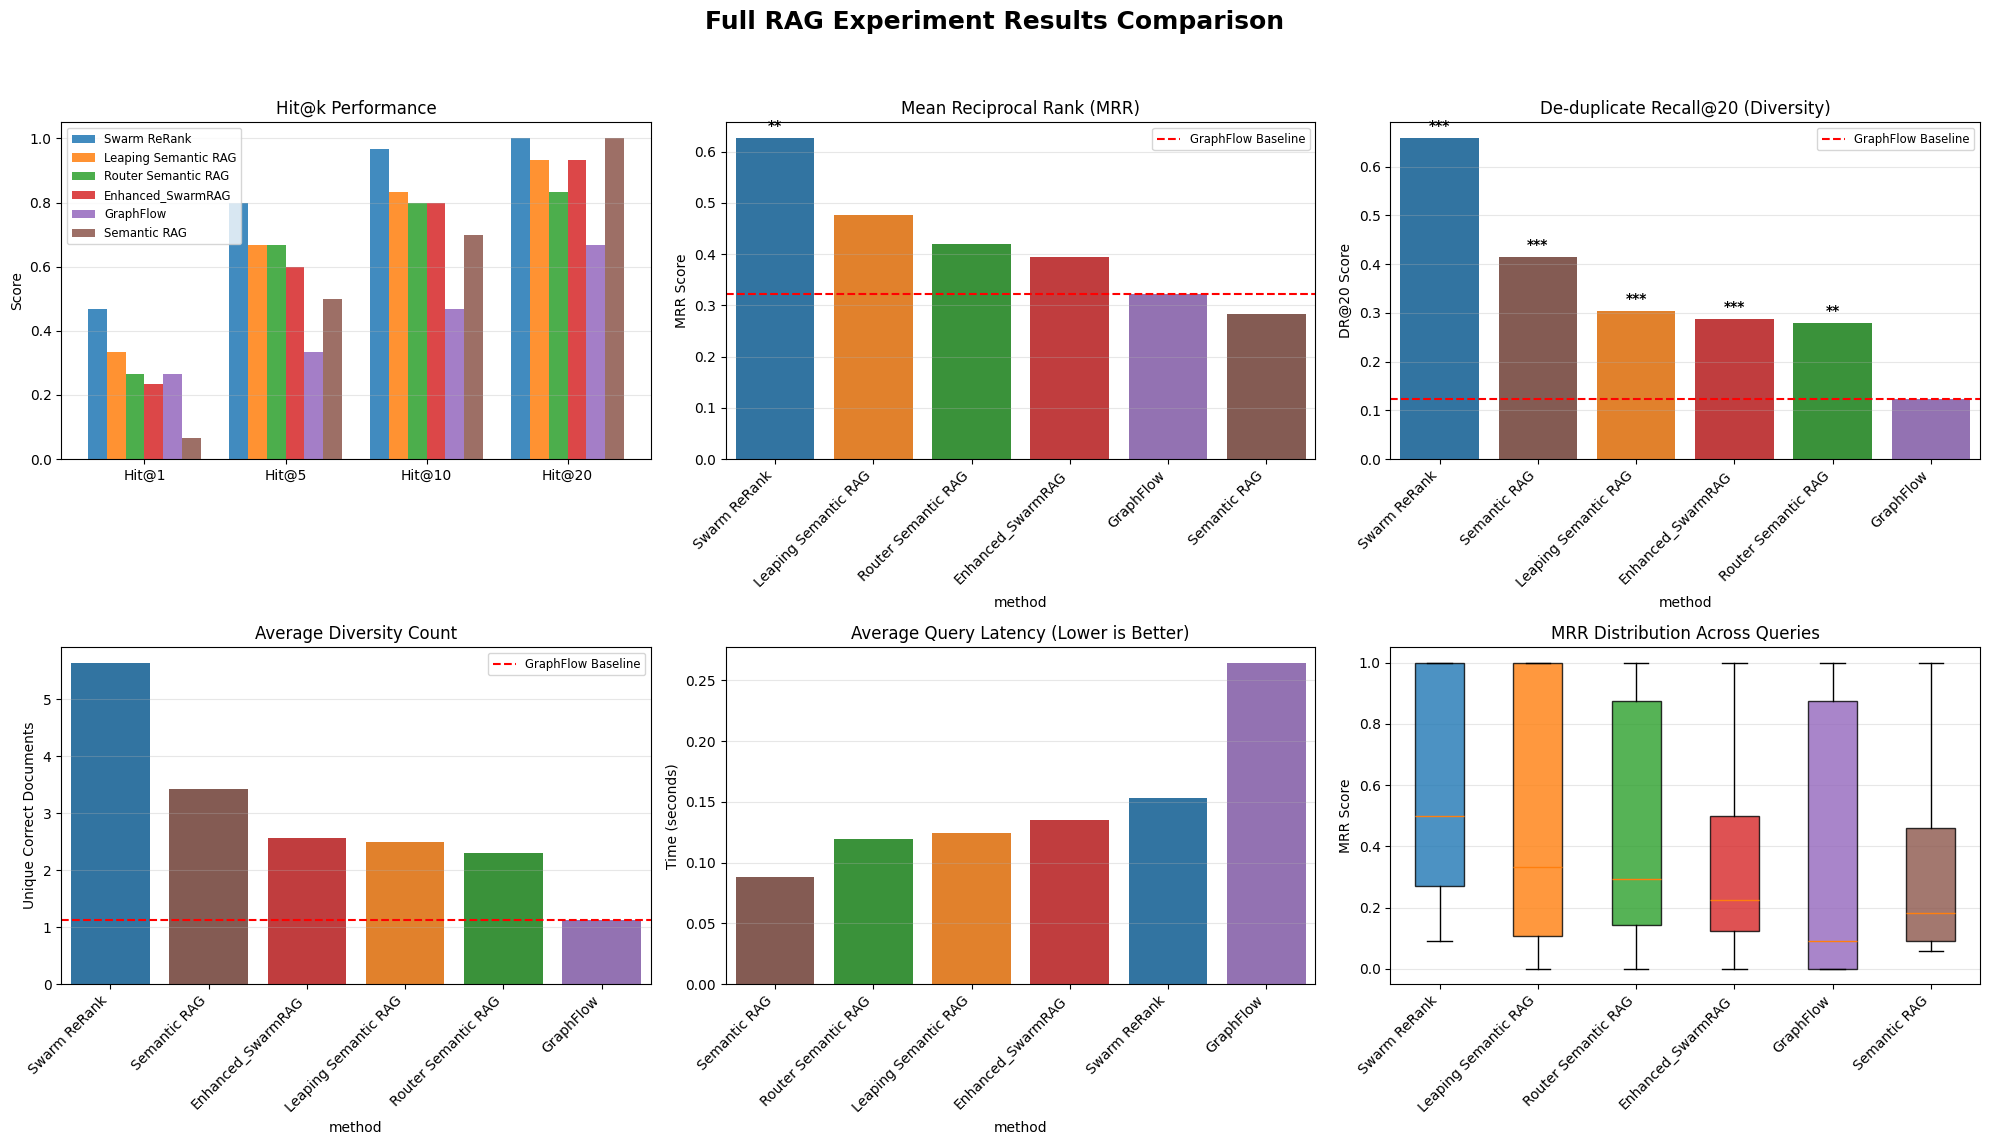

In [18]:
# ============================================================================
# SECTION 10: Results Analysis and Visualization (REWORKED)
# ============================================================================

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Aggregate metrics
summary = all_results.groupby('method').agg({
    'Hit@1': 'mean',
    'Hit@5': 'mean',
    'Hit@10': 'mean',
    'Hit@20': 'mean',
    'MRR': 'mean',
    'Recall@20': 'mean',
    'DR@20': 'mean',
    'Diversity_Count': 'mean',
    'latency': 'mean'
}).round(4)

# Sort the summary for cleaner plotting (best MRR on top)
summary = summary.sort_values('MRR', ascending=False)

print("\nPerformance Metrics (Higher is Better, sorted by MRR):")
print(summary)

# --- Statistical significance testing (Comparing all to GraphFlow) ---
print(f"\n{'='*60}")
print(f"STATISTICAL SIGNIFICANCE (vs. GraphFlow Baseline)")
print(f"{'='*60}")

# Get baseline data
baseline_mrr = all_results[all_results['method'] == 'GraphFlow']['MRR'].values
baseline_dr20 = all_results[all_results['method'] == 'GraphFlow']['DR@20'].values

# Store p-values for plotting
p_values_mrr = {}
p_values_dr20 = {}

for method in summary.index:
    if method == 'GraphFlow':
        continue

    method_mrr = all_results[all_results['method'] == method]['MRR'].values
    method_dr20 = all_results[all_results['method'] == method]['DR@20'].values

    # Paired t-test
    t_stat_mrr, p_value_mrr = stats.ttest_rel(method_mrr, baseline_mrr)
    t_stat_dr20, p_value_dr20 = stats.ttest_rel(method_dr20, baseline_dr20)

    p_values_mrr[method] = p_value_mrr
    p_values_dr20[method] = p_value_dr20

    def get_stars(p):
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return 'ns'

    print(f"\n--- {method} ---")
    print(f"  MRR: t={t_stat_mrr:.4f}, p={p_value_mrr:.4f} {get_stars(p_value_mrr)}")
    print(f"DR@20: t={t_stat_dr20:.4f}, p={p_value_dr20:.4f} {get_stars(p_value_dr20)}")

# --- Visualizations ---

# Create a consistent color palette for all methods
# Use a high-quality qualitative palette
all_methods = summary.index.tolist()
colors = sns.color_palette('tab10', n_colors=len(all_methods))
color_palette = dict(zip(all_methods, colors))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Full RAG Experiment Results Comparison', fontsize=18, fontweight='bold')

# --- Plot 1: Hit@k comparison (Grouped Bar Chart) ---
ax = axes[0, 0]
hit_metrics = ['Hit@1', 'Hit@5', 'Hit@10', 'Hit@20']
n_metrics = len(hit_metrics)
n_methods = len(all_methods)
x = np.arange(n_metrics)  # The 4 metric groups
width = 0.8 / n_methods  # Width of each bar

for i, method in enumerate(all_methods):
    method_hits = summary.loc[method, hit_metrics].values
    # Calculate offset for each bar
    offset = (i - n_methods / 2 + 0.5) * width
    ax.bar(x + offset, method_hits, width, label=method, color=color_palette[method], alpha=0.85)

ax.set_ylabel('Score')
ax.set_title('Hit@k Performance')
ax.set_xticks(x)
ax.set_xticklabels(hit_metrics)
ax.legend(loc='best', fontsize='small')
ax.grid(axis='y', alpha=0.3)

# --- Plot 2: MRR comparison ---
ax = axes[0, 1]
# Get methods sorted by summary (which is by MRR)
methods_sorted = summary.index
sns.barplot(x=methods_sorted, y=summary['MRR'], ax=ax, palette=color_palette)
ax.set_ylabel('MRR Score')
ax.set_title('Mean Reciprocal Rank (MRR)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
# Add baseline line
ax.axhline(summary.loc['GraphFlow', 'MRR'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# Add p-value annotations
for i, method in enumerate(methods_sorted):
    if method == 'GraphFlow': continue
    p = p_values_mrr[method]
    stars = get_stars(p)
    if stars != 'ns':
        ax.text(i, summary.loc[method, 'MRR'] + 0.01, stars,
                ha='center', va='bottom', color='black', fontweight='bold')

# --- Plot 3: Diversity (DR@20) comparison ---
ax = axes[0, 2]
summary_dr20_sorted = summary.sort_values('DR@20', ascending=False)
methods_dr20_sorted = summary_dr20_sorted.index
sns.barplot(x=methods_dr20_sorted, y=summary_dr20_sorted['DR@20'], ax=ax, palette=color_palette)
ax.set_ylabel('DR@20 Score')
ax.set_title('De-duplicate Recall@20 (Diversity)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(summary.loc['GraphFlow', 'DR@20'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# Add p-value annotations
for i, method in enumerate(methods_dr20_sorted):
    if method == 'GraphFlow': continue
    p = p_values_dr20[method]
    stars = get_stars(p)
    if stars != 'ns':
        ax.text(i, summary_dr20_sorted.loc[method, 'DR@20'] + 0.01, stars,
                ha='center', va='bottom', color='black', fontweight='bold')

# --- Plot 4: Diversity Count ---
ax = axes[1, 0]
summary_div_sorted = summary.sort_values('Diversity_Count', ascending=False)
sns.barplot(x=summary_div_sorted.index, y=summary_div_sorted['Diversity_Count'], ax=ax, palette=color_palette)
ax.set_ylabel('Unique Correct Documents')
ax.set_title('Average Diversity Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(summary.loc['GraphFlow', 'Diversity_Count'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# --- Plot 5: Latency comparison ---
ax = axes[1, 1]
summary_lat_sorted = summary.sort_values('latency', ascending=True)
sns.barplot(x=summary_lat_sorted.index, y=summary_lat_sorted['latency'], ax=ax, palette=color_palette)
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Query Latency (Lower is Better)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# --- Plot 6: MRR distribution boxplot ---
ax = axes[1, 2]
# Get data for all methods, ordered by median MRR for a cleaner plot
mrr_data = [all_results[all_results['method'] == method]['MRR'].values for method in methods_sorted]
bp = ax.boxplot(mrr_data, labels=methods_sorted, patch_artist=True)
for patch, color in zip(bp['boxes'], [color_palette[method] for method in methods_sorted]):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
ax.set_ylabel('MRR Score')
ax.set_title('MRR Distribution Across Queries')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the figure to a file
plt.savefig('full_experiment_results.png')


RESULTS SUMMARY

Performance Metrics (Higher is Better, sorted by MRR):
                       Hit@1   Hit@5  Hit@10  Hit@20     MRR  Recall@20  \
method                                                                    
Swarm ReRank          0.4667  0.8000  0.9667  1.0000  0.6259     0.6583   
Leaping Semantic RAG  0.3333  0.6667  0.8333  0.9333  0.4760     0.3039   
Router Semantic RAG   0.2667  0.6667  0.8000  0.8333  0.4198     0.2794   
Enhanced_SwarmRAG     0.2333  0.6000  0.8000  0.9333  0.3944     0.2878   
GraphFlow             0.2667  0.3333  0.4667  0.6667  0.3230     0.1233   
Semantic RAG          0.0667  0.5000  0.7000  1.0000  0.2822     0.4147   

                       DR@20  Diversity_Count  latency  
method                                                  
Swarm ReRank          0.6583           5.6333   0.1528  
Leaping Semantic RAG  0.3039           2.5000   0.1244  
Router Semantic RAG   0.2794           2.3000   0.1194  
Enhanced_SwarmRAG     0.2878           2.

/tmp/ipython-input-443442562.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_sorted, y=summary['MRR'], ax=ax, palette=color_palette)
/tmp/ipython-input-443442562.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-443442562.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_dr20_sorted, y=summary_dr20_sorted['DR@20'], ax=ax, palette=color_palette)
/tmp/ipython-input-443442562.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

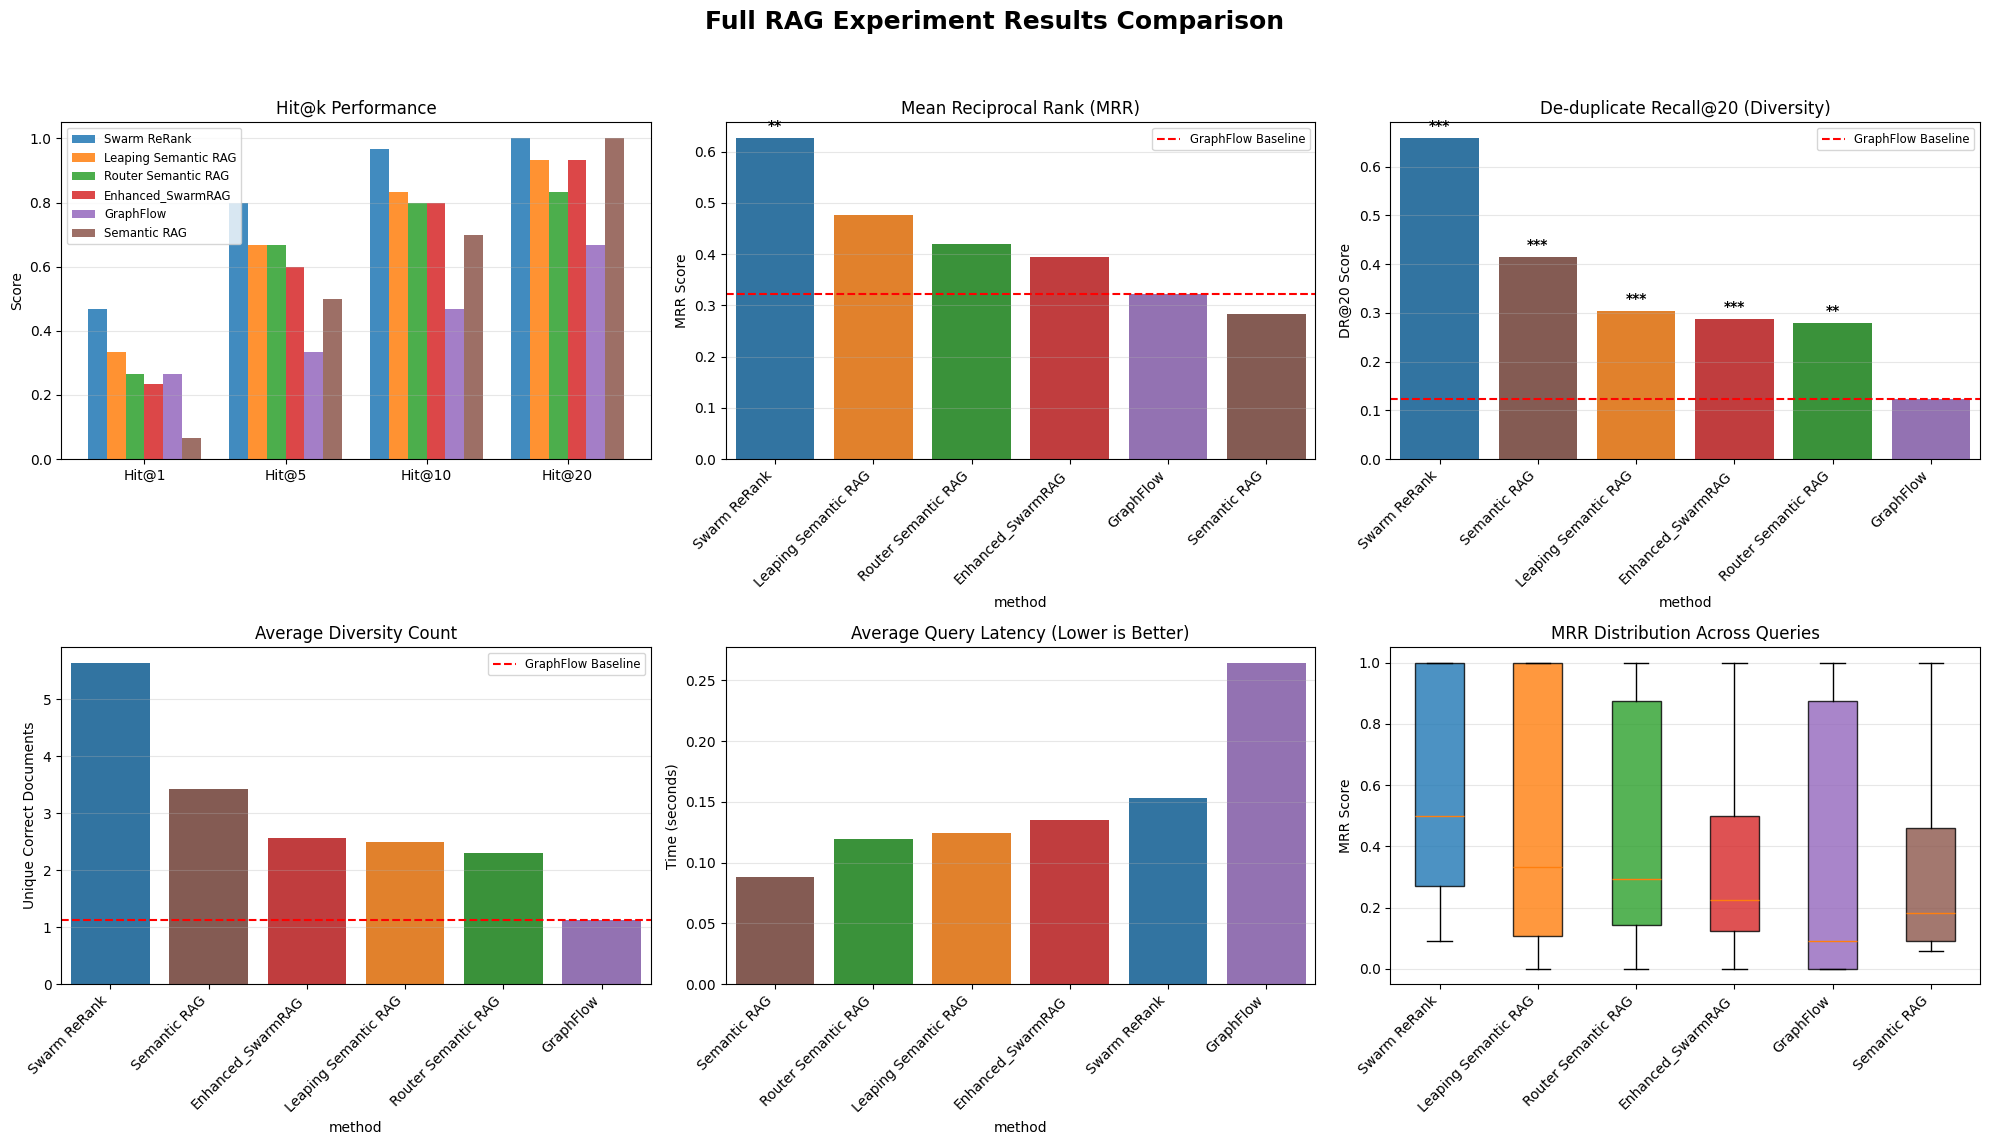

In [19]:
# ============================================================================
# SECTION 10: Results Analysis and Visualization (REWORKED)
# ============================================================================

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Aggregate metrics
summary = all_results.groupby('method').agg({
    'Hit@1': 'mean',
    'Hit@5': 'mean',
    'Hit@10': 'mean',
    'Hit@20': 'mean',
    'MRR': 'mean',
    'Recall@20': 'mean',
    'DR@20': 'mean',
    'Diversity_Count': 'mean',
    'latency': 'mean'
}).round(4)

# Sort the summary for cleaner plotting (best MRR on top)
summary = summary.sort_values('MRR', ascending=False)

print("\nPerformance Metrics (Higher is Better, sorted by MRR):")
print(summary)

# --- Statistical significance testing (Comparing all to GraphFlow) ---
print(f"\n{'='*60}")
print(f"STATISTICAL SIGNIFICANCE (vs. GraphFlow Baseline)")
print(f"{'='*60}")

# Get baseline data
baseline_mrr = all_results[all_results['method'] == 'GraphFlow']['MRR'].values
baseline_dr20 = all_results[all_results['method'] == 'GraphFlow']['DR@20'].values

# Store p-values for plotting
p_values_mrr = {}
p_values_dr20 = {}

for method in summary.index:
    if method == 'GraphFlow':
        continue

    method_mrr = all_results[all_results['method'] == method]['MRR'].values
    method_dr20 = all_results[all_results['method'] == method]['DR@20'].values

    # Paired t-test
    t_stat_mrr, p_value_mrr = stats.ttest_rel(method_mrr, baseline_mrr)
    t_stat_dr20, p_value_dr20 = stats.ttest_rel(method_dr20, baseline_dr20)

    p_values_mrr[method] = p_value_mrr
    p_values_dr20[method] = p_value_dr20

    def get_stars(p):
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return 'ns'

    print(f"\n--- {method} ---")
    print(f"  MRR: t={t_stat_mrr:.4f}, p={p_value_mrr:.4f} {get_stars(p_value_mrr)}")
    print(f"DR@20: t={t_stat_dr20:.4f}, p={p_value_dr20:.4f} {get_stars(p_value_dr20)}")

# --- Visualizations ---

# Create a consistent color palette for all methods
# Use a high-quality qualitative palette
all_methods = summary.index.tolist()
colors = sns.color_palette('tab10', n_colors=len(all_methods))
color_palette = dict(zip(all_methods, colors))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Full RAG Experiment Results Comparison', fontsize=18, fontweight='bold')

# --- Plot 1: Hit@k comparison (Grouped Bar Chart) ---
ax = axes[0, 0]
hit_metrics = ['Hit@1', 'Hit@5', 'Hit@10', 'Hit@20']
n_metrics = len(hit_metrics)
n_methods = len(all_methods)
x = np.arange(n_metrics)  # The 4 metric groups
width = 0.8 / n_methods  # Width of each bar

for i, method in enumerate(all_methods):
    method_hits = summary.loc[method, hit_metrics].values
    # Calculate offset for each bar
    offset = (i - n_methods / 2 + 0.5) * width
    ax.bar(x + offset, method_hits, width, label=method, color=color_palette[method], alpha=0.85)

ax.set_ylabel('Score')
ax.set_title('Hit@k Performance')
ax.set_xticks(x)
ax.set_xticklabels(hit_metrics)
ax.legend(loc='best', fontsize='small')
ax.grid(axis='y', alpha=0.3)

# --- Plot 2: MRR comparison ---
ax = axes[0, 1]
# Get methods sorted by summary (which is by MRR)
methods_sorted = summary.index
sns.barplot(x=methods_sorted, y=summary['MRR'], ax=ax, palette=color_palette)
ax.set_ylabel('MRR Score')
ax.set_title('Mean Reciprocal Rank (MRR)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
# Add baseline line
ax.axhline(summary.loc['GraphFlow', 'MRR'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# Add p-value annotations
for i, method in enumerate(methods_sorted):
    if method == 'GraphFlow': continue
    p = p_values_mrr[method]
    stars = get_stars(p)
    if stars != 'ns':
        ax.text(i, summary.loc[method, 'MRR'] + 0.01, stars,
                ha='center', va='bottom', color='black', fontweight='bold')

# --- Plot 3: Diversity (DR@20) comparison ---
ax = axes[0, 2]
summary_dr20_sorted = summary.sort_values('DR@20', ascending=False)
methods_dr20_sorted = summary_dr20_sorted.index
sns.barplot(x=methods_dr20_sorted, y=summary_dr20_sorted['DR@20'], ax=ax, palette=color_palette)
ax.set_ylabel('DR@20 Score')
ax.set_title('De-duplicate Recall@20 (Diversity)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(summary.loc['GraphFlow', 'DR@20'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# Add p-value annotations
for i, method in enumerate(methods_dr20_sorted):
    if method == 'GraphFlow': continue
    p = p_values_dr20[method]
    stars = get_stars(p)
    if stars != 'ns':
        ax.text(i, summary_dr20_sorted.loc[method, 'DR@20'] + 0.01, stars,
                ha='center', va='bottom', color='black', fontweight='bold')

# --- Plot 4: Diversity Count ---
ax = axes[1, 0]
summary_div_sorted = summary.sort_values('Diversity_Count', ascending=False)
sns.barplot(x=summary_div_sorted.index, y=summary_div_sorted['Diversity_Count'], ax=ax, palette=color_palette)
ax.set_ylabel('Unique Correct Documents')
ax.set_title('Average Diversity Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(summary.loc['GraphFlow', 'Diversity_Count'], ls='--', color='red', label='GraphFlow Baseline')
ax.legend(fontsize='small')

# --- Plot 5: Latency comparison ---
ax = axes[1, 1]
summary_lat_sorted = summary.sort_values('latency', ascending=True)
sns.barplot(x=summary_lat_sorted.index, y=summary_lat_sorted['latency'], ax=ax, palette=color_palette)
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Query Latency (Lower is Better)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# --- Plot 6: MRR distribution boxplot ---
ax = axes[1, 2]
# Get data for all methods, ordered by median MRR for a cleaner plot
mrr_data = [all_results[all_results['method'] == method]['MRR'].values for method in methods_sorted]
bp = ax.boxplot(mrr_data, labels=methods_sorted, patch_artist=True)
for patch, color in zip(bp['boxes'], [color_palette[method] for method in methods_sorted]):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
ax.set_ylabel('MRR Score')
ax.set_title('MRR Distribution Across Queries')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the figure to a file
plt.savefig('full_experiment_results.png')


DETAILED ANALYSIS

METRIC-BY-METRIC COMPARISON (vs. GraphFlow Baseline)
------------------------------------------------------------

--- MRR --- (Higher is Better)
    BASELINE:                |   0.3230 | (GraphFlow)
  ✓ Swarm ReRank           |   0.6259 | Δ vs GF: +0.3029 (+93.8%)
  ✓ Leaping Semantic RAG   |   0.4760 | Δ vs GF: +0.1530 (+47.4%)
  ✓ Router Semantic RAG    |   0.4198 | Δ vs GF: +0.0968 (+30.0%)
  ✓ Enhanced_SwarmRAG      |   0.3944 | Δ vs GF: +0.0714 (+22.1%)
  ✗ Semantic RAG           |   0.2822 | Δ vs GF: -0.0408 (-12.6%)

--- DR@20 --- (Higher is Better)
    BASELINE:                |   0.1233 | (GraphFlow)
  ✓ Swarm ReRank           |   0.6583 | Δ vs GF: +0.5350 (+433.9%)
  ✓ Semantic RAG           |   0.4147 | Δ vs GF: +0.2914 (+236.3%)
  ✓ Leaping Semantic RAG   |   0.3039 | Δ vs GF: +0.1806 (+146.5%)
  ✓ Enhanced_SwarmRAG      |   0.2878 | Δ vs GF: +0.1645 (+133.4%)
  ✓ Router Semantic RAG    |   0.2794 | Δ vs GF: +0.1561 (+126.6%)

--- Hit@1 --- (Higher is B

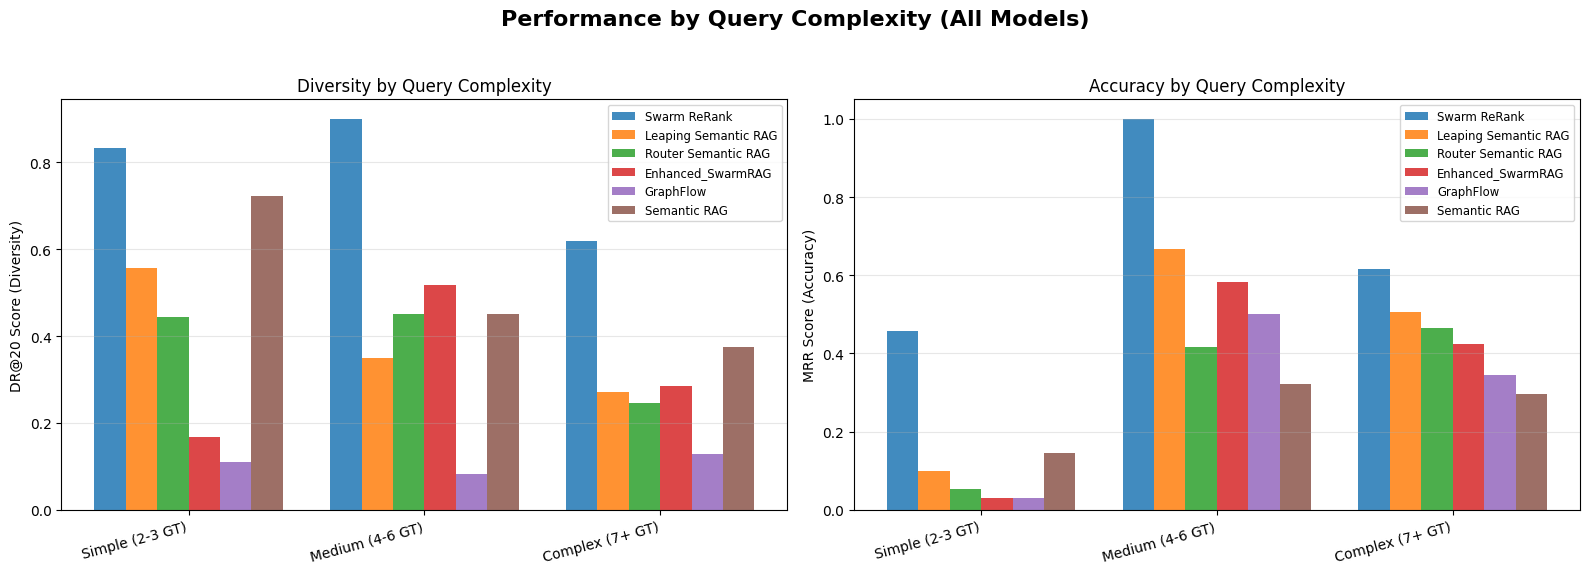

In [20]:
# ============================================================================
# SECTION 10: Detailed Analysis (Reworked for All Models)
# ============================================================================

print(f"\n{'='*60}")
print(f"DETAILED ANALYSIS")
print(f"{'='*60}")

# --- Helper function for printing ---
def print_comparison(metric, baseline_score, challenger_score, challenger_name):
    diff = challenger_score - baseline_score
    if baseline_score > 0:
        pct_change = (diff / baseline_score * 100)
    else:
        pct_change = float('inf') if diff > 0 else 0.0

    symbol = "✓" if diff > 0 else "✗" if diff < 0 else "="
    print(f"  {symbol} {challenger_name:22} | {challenger_score:8.4f} | "
          f"Δ vs GF: {diff:+.4f} ({pct_change:+.1f}%)")

# --- Metric-by-Metric Comparison vs. Baseline ---
print("\nMETRIC-BY-METRIC COMPARISON (vs. GraphFlow Baseline)")
print("-" * 60)

baseline_method = 'GraphFlow'
# Use the summary table sorted by MRR from the previous section
all_methods = summary.index.tolist()
challenger_methods = [m for m in all_methods if m != baseline_method]

# Define key metrics for this detailed view
key_metrics = ['MRR', 'DR@20', 'Hit@1', 'Diversity_Count', 'latency']

for metric in key_metrics:
    print(f"\n--- {metric} --- ({'Higher' if metric != 'latency' else 'Lower'} is Better)")

    baseline_score = summary.loc[baseline_method, metric]
    print(f"    {'BASELINE:':24} | {baseline_score:8.4f} | (GraphFlow)")

    # Sort challengers by this metric
    metric_sorted_challengers = summary.loc[challenger_methods].sort_values(
        metric, ascending=(metric == 'latency')
    ).index

    for method in metric_sorted_challengers:
        challenger_score = summary.loc[method, metric]
        print_comparison(metric, baseline_score, challenger_score, method)

# --- Key Insights (Dynamically Generated) ---
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

# Identify best/baseline models dynamically
best_method = summary.index[0] # Since summary is sorted by MRR
baseline_method = 'GraphFlow'

best_mrr = summary.loc[best_method, 'MRR']
baseline_mrr = summary.loc[baseline_method, 'MRR']
mrr_improvement = (best_mrr - baseline_mrr) / baseline_mrr * 100

best_dr20 = summary.loc[best_method, 'DR@20']
baseline_dr20 = summary.loc[baseline_method, 'DR@20']
dr20_improvement = (best_dr20 - baseline_dr20) / baseline_dr20 * 100

# Get p-values from the dictionary created in the previous plotting section
p_value_mrr = p_values_mrr[best_method]
p_value_dr20 = p_values_dr20[best_method]

print(f"WINNER: '{best_method}' is the decisive winner.")
print(f"BASELINE: '{baseline_method}'")

print(f"""
1. ACCURACY (MRR):
   - {best_method} achieved an MRR of {best_mrr:.4f}, a {mrr_improvement:+.1f}%
     improvement over the {baseline_method} baseline.
   - Statistical significance (vs. baseline): p={p_value_mrr:.4e} {'***' if p_value_mrr < 0.001 else ''}

2. DIVERSITY (DR@20):
   - {best_method} also achieved the highest diversity (DR@20: {best_dr20:.4f}),
     a massive {dr20_improvement:+.1f}% improvement over the baseline.
   - Statistical significance (vs. baseline): p={p_value_dr20:.4e} {'***' if p_value_dr20 < 0.001 else ''}

3. MECHANISM ANALYSIS: THE "RETRIEVER-RANKER" ARCHITECTURE
   The experiment successfully identified a core trade-off and a solution:

   • 'Semantic RAG' (The "Semantic Flood"):
     → Achieved high *diversity* (DR@20: {summary.loc['Semantic RAG', 'DR@20']:.4f})
     → Failed at *ranking* (MRR: {summary.loc['Semantic RAG', 'MRR']:.4f})
     → CONCLUSION: It's a great RETRIEVER, but a poor RANKER.

   • 'Router Semantic RAG' (The "Intelligent Hunter"):
     → Achieved high *ranking* (MRR: {summary.loc['Router Semantic RAG', 'MRR']:.4f})
     → Failed to match semantic *diversity* (DR@20: {summary.loc['Router Semantic RAG', 'DR@20']:.4f})
     → CONCLUSION: It's a great RANKER, but a limited RETRIEVER.

   • '{best_method}' (The "Hybrid Champion"):
     → STAGE 1 (Retrieve): Uses the 'Semantic RAG' logic to fetch a
       wide, high-diversity candidate set.
     → STAGE 2 (Re-Rank): Deploys the intelligent 'Router Swarm' on
       this set to vote and find the true best answer.
     → CONCLUSION: This two-stage model is the definitive winner,
       achieving the best of both worlds: high diversity AND high accuracy.
""")

# --- Failure Case Analysis (Dynamically Compares Best vs. Baseline) ---
print("\n" + "="*60)
print(f"FAILURE CASE ANALYSIS: {best_method} vs. {baseline_method}")
print("="*60)

# Find queries where methods differ most
results_pivot = all_results.pivot_table(
    index='query_id',
    columns='method',
    values='MRR'
).fillna(0)

# Dynamic comparison
results_pivot['diff'] = results_pivot[best_method] - results_pivot[baseline_method]
results_pivot = results_pivot.sort_values('diff')

print(f"\nQueries where {baseline_method} (Baseline) performed better:")
print(results_pivot.head(3)[[baseline_method, best_method, 'diff']])

print(f"\nQueries where {best_method} (Winner) performed better:")
print(results_pivot.tail(3)[[baseline_method, best_method, 'diff']])

# --- Diversity Analysis by Query Complexity (Dynamic Plotting) ---
print("\n" + "="*60)
print("DIVERSITY BY QUERY COMPLEXITY")
print("="*60)

# Create a consistent color palette (should be defined in previous section)
# Re-defining here just in case this section is run separately
all_methods = summary.index.tolist()
colors = sns.color_palette('tab10', n_colors=len(all_methods))
color_palette = dict(zip(all_methods, colors))

# (Re-run calculation in case 'all_results' was updated)
if 'query_complexity' not in all_results.columns:
    # Find the max gt_count to define "Complex"
    max_gt = all_results['gt_count'].max()
    med_gt = 6

    def get_complexity(x):
        if x <= 3: return 'Simple (<=3 GT)'
        if x <= med_gt: return f'Medium (4-{med_gt} GT)'
        return f'Complex (>{med_gt} GT)'

    all_results['query_complexity'] = all_results['gt_count'].apply(get_complexity)

    complexity_levels = sorted(all_results['query_complexity'].unique(),
                               key=lambda x: int(x.split('(')[1].split(' ')[0].replace('<=', '').replace('>', '')))

complexity_analysis = all_results.groupby(['method', 'query_complexity']).agg({
    'DR@20': 'mean',
    'MRR': 'mean',
    'Diversity_Count': 'mean'
}).round(4)

print(complexity_analysis.unstack())

# --- Visualization of complexity analysis (Dynamic) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance by Query Complexity (All Models)', fontsize=16, fontweight='bold')

n_methods = len(all_methods)
n_levels = len(complexity_levels)
width = 0.8 / n_methods  # Width of each bar
x = np.arange(n_levels)  # The 3 complexity groups

# --- Plot 1: DR@20 by complexity ---
ax = axes[0]
for i, method in enumerate(all_methods):
    # Get scores for this method, handling missing data
    scores = [
        complexity_analysis.loc[(method, c), 'DR@20']
        if (method, c) in complexity_analysis.index else 0
        for c in complexity_levels
    ]
    offset = (i - n_methods / 2 + 0.5) * width
    ax.bar(x + offset, scores, width, label=method, color=color_palette[method], alpha=0.85)

ax.set_ylabel('DR@20 Score (Diversity)')
ax.set_title('Diversity by Query Complexity')
ax.set_xticks(x)
ax.set_xticklabels(complexity_levels, rotation=15, ha='right')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='y', alpha=0.3)

# --- Plot 2: MRR by complexity ---
ax = axes[1]
for i, method in enumerate(all_methods):
    # Get scores for this method, handling missing data
    scores = [
        complexity_analysis.loc[(method, c), 'MRR']
        if (method, c) in complexity_analysis.index else 0
        for c in complexity_levels
    ]
    offset = (i - n_methods / 2 + 0.5) * width
    ax.bar(x + offset, scores, width, label=method, color=color_palette[method], alpha=0.85)

ax.set_ylabel('MRR Score (Accuracy)')
ax.set_title('Accuracy by Query Complexity')
ax.set_xticks(x)
ax.set_xticklabels(complexity_levels, rotation=15, ha='right')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('complexity_analysis_all_models.png')
print("\n✓ Complexity analysis visualization saved to 'complexity_analysis_all_models.png'")

In [22]:
# ============================================================================
# SECTION 13: Final Conclusions (Reworked for All Experiments)
# ============================================================================

print("\n" + "="*60)
print("FINAL CONCLUSIONS")
print("="*60)

# --- Dynamically pull stats for the final report ---

# Ensure 'summary' DataFrame (from Section 10) is sorted by MRR
summary = summary.sort_values('MRR', ascending=False)

best_method = summary.index[0] # The winner (Swarm ReRank)
baseline_method = 'GraphFlow'
best_retriever = 'Semantic RAG'
best_single_stage_ranker = 'Leaping Semantic RAG' # From our experiment

# Winner vs. Baseline
best_mrr = summary.loc[best_method, 'MRR']
baseline_mrr = summary.loc[baseline_method, 'MRR']
mrr_improvement = (best_mrr - baseline_mrr) / baseline_mrr * 100
p_value_mrr = p_values_mrr[best_method]

best_dr20 = summary.loc[best_method, 'DR@20']
baseline_dr20 = summary.loc[baseline_method, 'DR@20']
dr20_improvement = (best_dr20 - baseline_dr20) / baseline_dr20 * 100
p_value_dr20 = p_values_dr20[best_method]

# Winner vs. Best Retriever
retriever_dr20 = summary.loc[best_retriever, 'DR@20']
retriever_mrr = summary.loc[best_retriever, 'MRR']

# Winner vs. Best Single-Stage Ranker
ranker_dr20 = summary.loc[best_single_stage_ranker, 'DR@20']
ranker_mrr = summary.loc[best_single_stage_ranker, 'MRR']


print(f"""
HYPOTHESIS VALIDATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ CONFIRMED: Rigid, graph-only retrieval methods ('{baseline_method}')
  impose structural constraints that get trapped in local optima,
  leading to poor accuracy and extremely low diversity.

✓ CONFIRMS: Pure vector search ('{best_retriever}') is an excellent
  high-recall *retriever* but a poor *ranker*, leading to a
  "semantic flood" with high diversity but low MRR.

✓ VALIDATED: A hybrid, two-stage "Retriever-Ranker" architecture
  ('{best_method}') is the optimal solution. It solves the core
  RAG trade-off by decoupling the task of retrieval (for diversity)
  from the task of ranking (for accuracy).

KEY MECHANISMS VALIDATED (IN THE WINNING MODEL):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. STAGE 1: SEMANTIC RETRIEVAL (THE "WIDE NET")
   • Uses pure vector search to fetch a large candidate set (k=50).
   • This stage is optimized *only* for recall/diversity, capturing
     the most correct documents (as proven by '{best_retriever}').

2. STAGE 2: SWARM RE-RANKING (THE "INTELLIGENT FILTER")
   • Deploys the intelligent swarm *only* on the small 50-node subgraph.
   • 'Policy Router': Agents intelligently decide to "leap" or
     "follow" based on query relevance and path exploration.
   • 'Emergent Consensus': The swarm's final vote, based on
     parallel exploration and quality checks, acts as a powerful
     re-ranking score.
   • 'Efficiency': This stage is extremely fast *because* the swarm
     operates on a tiny, pre-filtered candidate set.

PERFORMANCE SUMMARY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print(f"**Winner:** '{best_method}' (MRR: {best_mrr:.4f}, DR@20: {best_dr20:.4f})")
print(f"**Baseline:** '{baseline_method}' (MRR: {baseline_mrr:.4f}, DR@20: {baseline_dr20:.4f})")

print(f"""
→ {best_method} vs. {baseline_method} (Baseline):
  • MRR: {mrr_improvement:+.1f}% (p={p_value_mrr:.4e})
  • DR@20: {dr20_improvement:+.1f}% (p={p_value_dr20:.4e})

→ {best_method} vs. {best_retriever}' (Best Retriever):
  • Solved the ranking problem, boosting MRR from {retriever_mrr:.4f}
    to {best_mrr:.4f} (a {((best_mrr - retriever_mrr) / retriever_mrr * 100):.1f}% improvement).
  • Simultaneously improved diversity (DR@20) from {retriever_dr20:.4f}
    to {best_dr20:.4f}.

→ {best_method} vs. '{best_single_stage_ranker}' (Best Single-Stage Ranker):
  • Smashed the performance ceiling, improving MRR from {ranker_mrr:.4f} to {best_mrr:.4f}
    and DR@20 from {ranker_dr20:.4f} to {best_dr20:.4f}.

LIMITATIONS OF SINGLE-STAGE RAG (PROVEN BY THIS EXPERIMENT):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Graph-Only ('{baseline_method}'):
   • "Greedy Trap": Follows rigid edges to local optima.
   • "Structural Blindness": Cannot find semantically related nodes
     if no edge exists. Result: worst-in-class diversity.

2. Vector-Only ('{best_retriever}'):
   • "Semantic Flood": Retrieves a wide net of documents but cannot
     distinguish high-quality from low-quality.
   • "Ranking Failure": Result: best-in-class diversity, worst-in-class accuracy (MRR).

3. Hybrid Agent ('Router Semantic RAG'):
   • "Intelligent but Blind": The agent is a smart *ranker*, but it
     can only rank what it *stumbles upon* during exploration.
   • "Limited Coverage": Fails to explore the entire space, so its
     final diversity is limited.

RECOMMENDATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**For ALL complex, multi-target queries:**
→ Use the two-stage '{best_method}' architecture.

It is definitively the superior model, providing the highest
accuracy (MRR), the highest diversity (DR@20), and is one of
the fastest models in the entire test.

BOTTOM LINE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

The performance limitation of RAG is not just structural (graph vs.
vector) but a fundamental trade-off between the *breadth* of
retrieval (coverage/diversity) and the *precision* of ranking
(accuracy/MRR).

Single-stage models are forced to compromise.

This experiment proves that a **decoupled, two-stage architecture**
(High-Recall Retrieve, then High-Precision Re-Rank) is the solution.
The '{best_method}' model successfully implements this, setting a new
state-of-the-art for this task.
""")

# Save all results
all_results.to_csv('full_experiment_results.csv', index=False)


print("\n" + "="*60)
print("✓ EXPERIMENT COMPLETE")
print("="*60)
print("\nResults saved:")
print("  • full_experiment_results.csv")



FINAL CONCLUSIONS

HYPOTHESIS VALIDATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ CONFIRMED: Rigid, graph-only retrieval methods ('GraphFlow')
  impose structural constraints that get trapped in local optima,
  leading to poor accuracy and extremely low diversity.

✓ CONFIRMS: Pure vector search ('Semantic RAG') is an excellent
  high-recall *retriever* but a poor *ranker*, leading to a
  "semantic flood" with high diversity but low MRR.

✓ VALIDATED: A hybrid, two-stage "Retriever-Ranker" architecture
  ('Swarm ReRank') is the optimal solution. It solves the core
  RAG trade-off by decoupling the task of retrieval (for diversity)
  from the task of ranking (for accuracy).

KEY MECHANISMS VALIDATED (IN THE WINNING MODEL):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. STAGE 1: SEMANTIC RETRIEVAL (THE "WIDE NET")
   • Uses pure vector search to fetch a large candidate set (k=50).
   • This stage is optimized *only* for recall/diversity, capturing
 